In [1]:
# Standard library imports
import os
import random
import json
from collections import Counter

# Third-party library imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
class CarPartsDataset(Dataset):
    def __init__(self, base_image_dir, txt_dir, label_mapping_file, transform=None, num_samples_per_model=10):
        """
        Args:
            base_image_dir (str): Base directory where images are stored.
                e.g., /data/NNDL/data/part
            txt_dir (str): Directory where text files for each part are stored.
                e.g., /data/NNDL/data/train_test_split/part
            label_mapping_file (str): Path to the JSON file containing label_to_idx mapping.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_samples_per_model (int): Number of datapoints to create per car model.
        """
        self.base_image_dir = base_image_dir
        self.txt_dir = txt_dir
        self.transform = transform
        self.num_samples_per_model = num_samples_per_model

        # Load the label mapping from JSON file.
        with open(label_mapping_file, 'r') as f:
            self.label_to_idx = json.load(f)

        # List to store datapoints as tuples: (list of 8 image paths, label)
        self.data = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        # Dictionary to group images by car model.
        # Format: grouped_data[car_model][part] = list of full image paths.
        grouped_data = {}

        # For each car part (1 to 8), read its text file.
        for part in range(1, 9):
            txt_file = os.path.join(self.txt_dir, f"test_part_{part}.txt")
            if not os.path.exists(txt_file):
                print(f"Warning: {txt_file} not found.")
                continue

            with open(txt_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    # Expected line format: car_make/car_model/year/part/filename.jpg
                    # Example: "78/1/2014/1/fa6d0ee4f0bcde.jpg"
                    parts = line.split('/')
                    if len(parts) < 5:
                        continue  # Skip invalid lines.
                    car_make = parts[0]
                    car_model = parts[1]
                    # Build the full path by joining the base directory and the relative path.
                    full_path = os.path.join(self.base_image_dir, line)
                    
                    # Initialize the car_model entry if not present.
                    if car_model not in grouped_data:
                        # Create an entry for parts 1 to 8.
                        grouped_data[car_model] = {str(i): [] for i in range(1, 9)}
                    
                    # Append the image to the corresponding part.
                    grouped_data[car_model][str(part)].append(full_path)

        # Create samples per car model.
        for car_model, parts_images in grouped_data.items():
            # Ensure that every part has at least one image.
            if not all(len(img_list) > 0 for img_list in parts_images.values()):
                continue

            # Map the car model to its label using the provided JSON mapping.
            if car_model not in self.label_to_idx:
                continue  # Skip if not found in the mapping.
            label = self.label_to_idx[car_model]

            # Create the specified number of samples for this car model.
            for _ in range(self.num_samples_per_model):
                sample_paths = []
                # Ensure a consistent order (parts 1 to 8).
                for part in sorted(parts_images.keys(), key=lambda x: int(x)):
                    chosen_img = random.choice(parts_images[part])
                    sample_paths.append(chosen_img)
                self.data.append((sample_paths, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
            images (list): List of 8 transformed images corresponding to each car part.
            label (int): The remapped car model label.
        """
        image_paths, label = self.data[idx]
        images = []
        for path in image_paths:
            # Open the image and convert to RGB.
            img = Image.open(path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            images.append(img)
        return images, label


In [3]:

# Define any image transformations (resize, tensor conversion, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add normalization or other transforms if needed.
])

# Path to the data directory and the label mapping JSON file.
data_root = "/data/NNDL/data/part"
label_mapping_file = "label_to_idx.json"

# Create the dataset.
dataset = CarPartsDataset( base_image_dir= '/data/NNDL/data/part', txt_dir= '/data/NNDL/data/train_test_split/part',
                            label_mapping_file=label_mapping_file,
                            transform=transform,
                            num_samples_per_model=10)

# Example: Get the first datapoint.
images, label = dataset[0]
print(f"Label: {label}")
print(f"Number of images: {len(images)}")


Label: 0
Number of images: 8


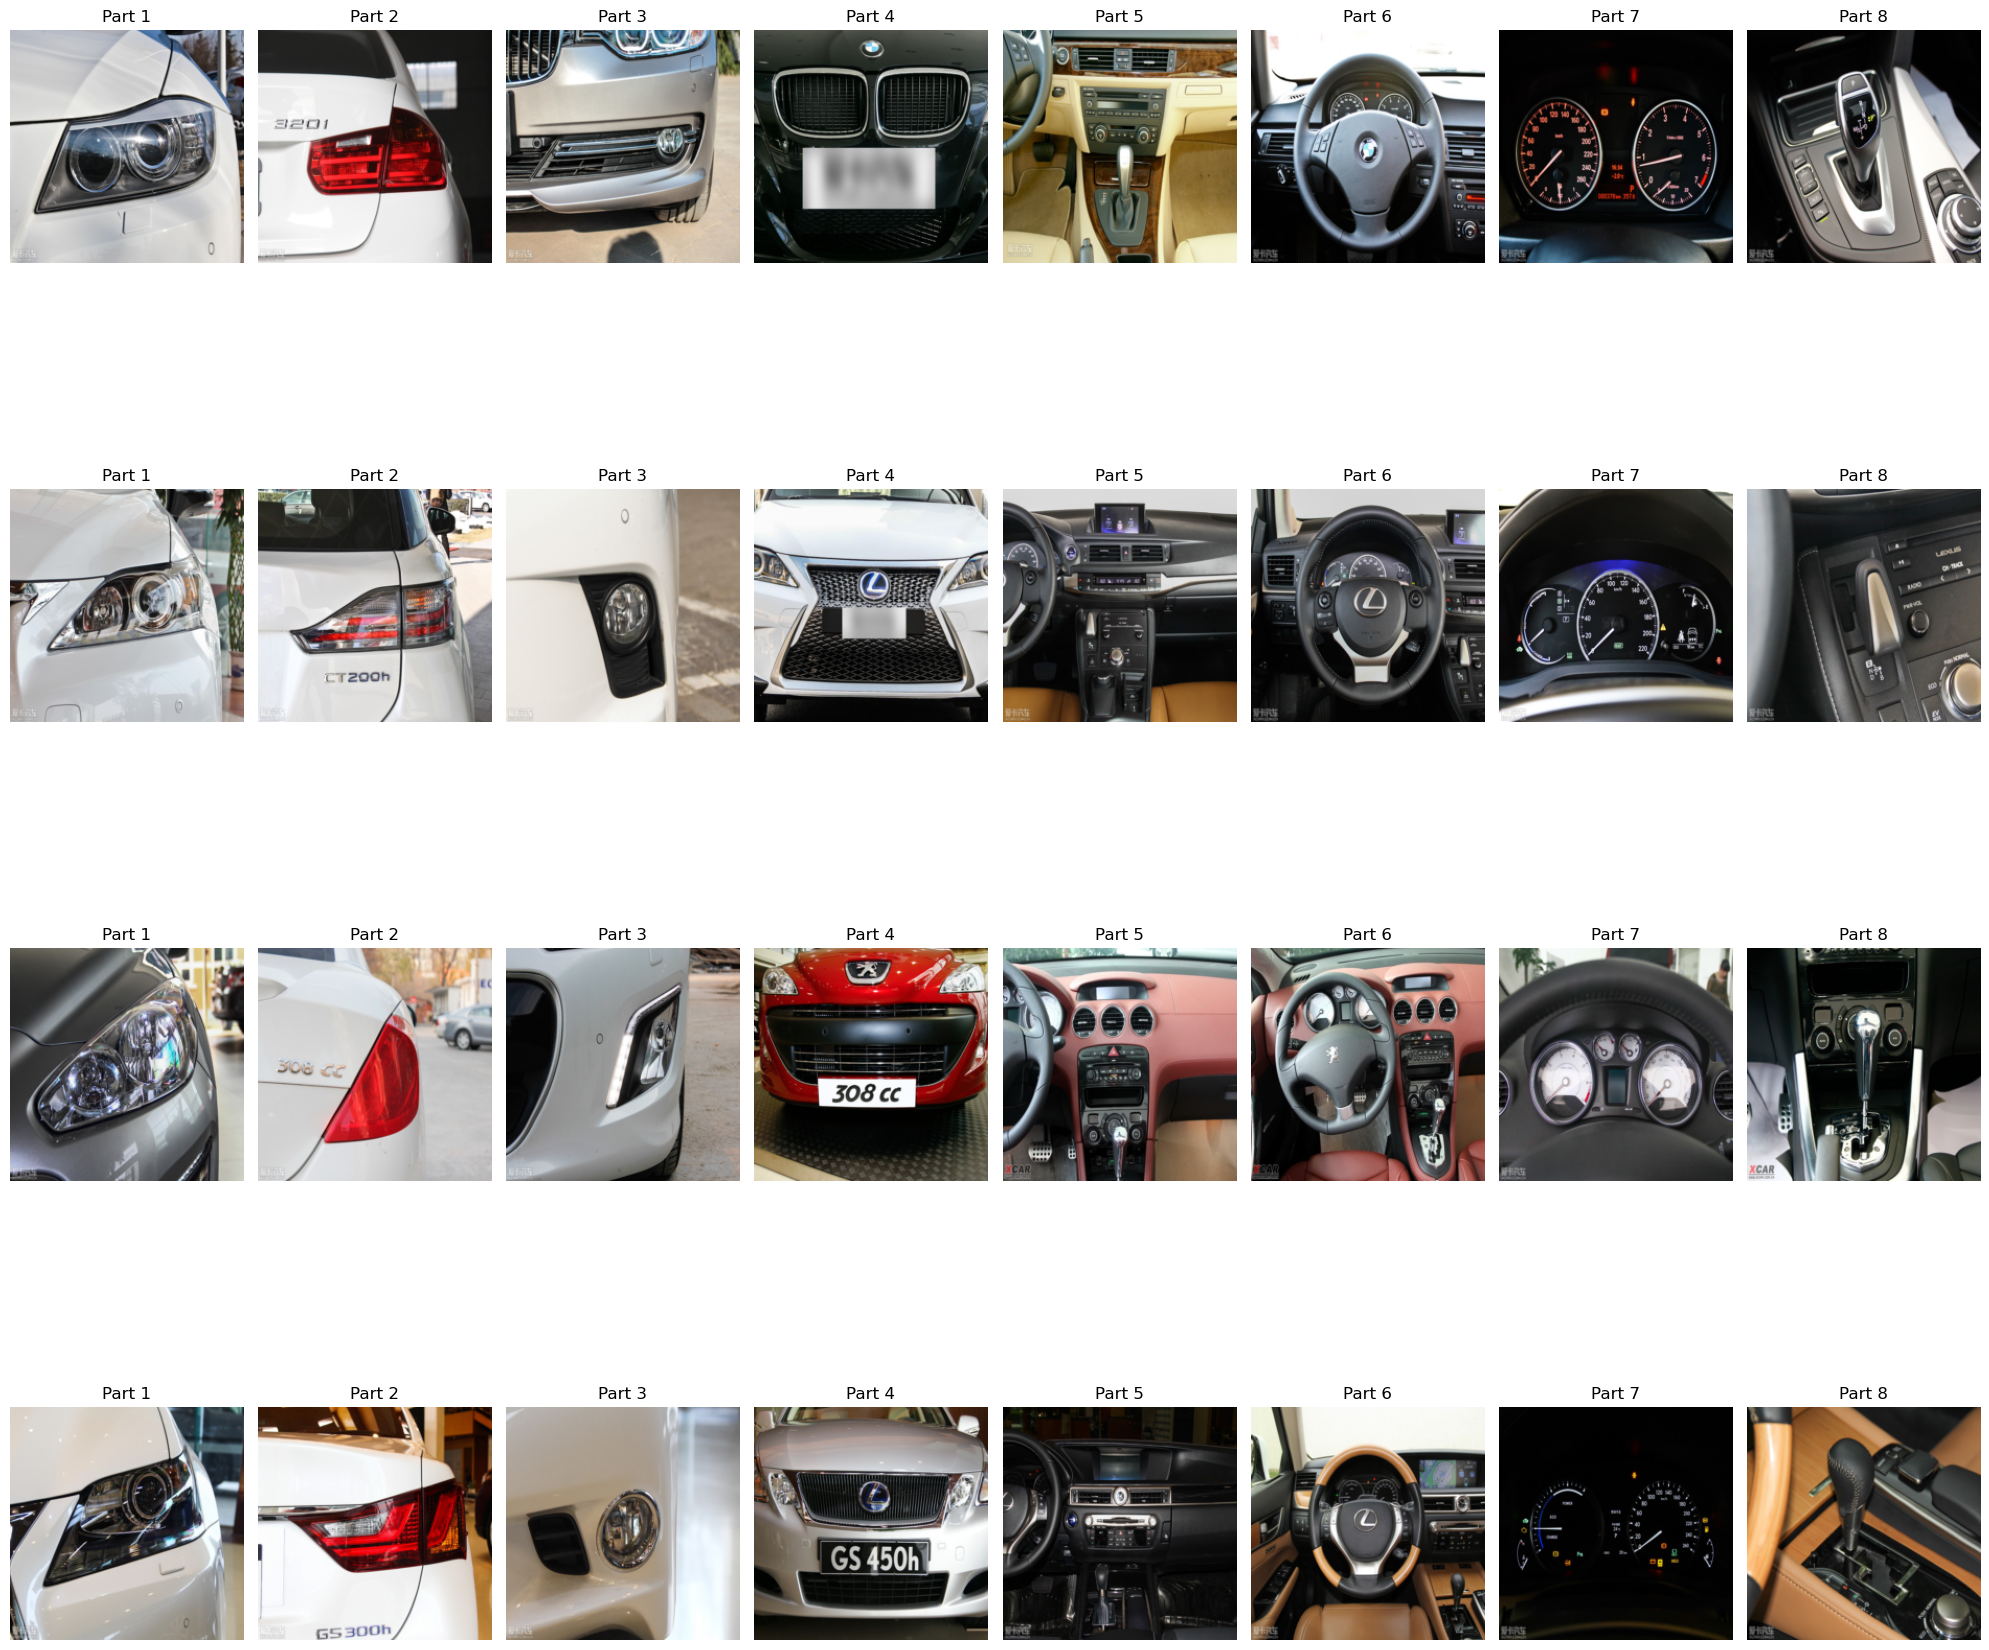

In [4]:
def plot_random_samples(dataset, num_samples=4):
    """
    Plot several random samples from the dataset.
    
    Args:
        dataset (Dataset): Instance of CarPartsDataset.
        num_samples (int): Number of random samples to plot.
    """
    # Randomly choose indices from the dataset.
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Create a figure with `num_samples` rows and 8 columns.
    fig, axes = plt.subplots(num_samples, 8, figsize=(20, 5*num_samples))
    
    # If there's only one sample, axes will be a 1D array, so wrap it in a list.
    if num_samples == 1:
        axes = [axes]
    
    for row_idx, sample_idx in enumerate(indices):
        images, label = dataset[sample_idx]
        
        # Iterate over the 8 car parts.
        for col_idx, img in enumerate(images):
            # Access the proper axis.
            ax = axes[row_idx][col_idx] if num_samples > 1 else axes[col_idx]
            
            # If the image is a tensor, convert it to a NumPy array for plotting.
            if isinstance(img, torch.Tensor):
                # Convert from (C, H, W) to (H, W, C)
                img_np = img.permute(1, 2, 0).numpy()
                # Clip values in case they're not in [0, 1]
                img_np = img_np.clip(0, 1)
            else:
                img_np = img
                
            ax.imshow(img_np)
            ax.axis('off')
            ax.set_title(f"Part {col_idx+1}")
        
        # Add the car model label as a ylabel for the first column of each row.
        axes[row_idx][0].set_ylabel(f"Label: {label}", fontsize=14, rotation=0, labelpad=50)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_random_samples(dataset, num_samples=4)


In [7]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################################
# 1. Define a custom collate function
#########################################
def custom_collate(batch):
    """
    Collate function for batching samples where each sample is a tuple:
      (list_of_8_images, label)
    This function groups images per car part and stacks labels.
    """
    images_list, labels = zip(*batch)  # images_list is a tuple of lists, labels is a tuple of ints.
    
    # For each car part, stack the corresponding images across the batch.
    # zip(*images_list) returns a tuple where each element is a tuple containing the i-th image from every sample.
    batch_images = [torch.stack(imgs, dim=0) for imgs in zip(*images_list)]
    batch_labels = torch.tensor(labels)
    return batch_images, batch_labels

#########################################
# 2. Create a DataLoader
#########################################
dataloader = DataLoader(
    dataset, 
    batch_size=32,        # adjust the batch size as needed
    shuffle=False, 
    num_workers=16, 
    pin_memory=True, 
    prefetch_factor=2, 
    persistent_workers=True,        # adjust based on your CPU cores
    collate_fn=custom_collate
)

#########################################
# 3. Load the models for each car part
#########################################
from collections import Counter
import torch.nn as nn
from torchvision import models

num_parts = 8
num_classes = len(dataset.label_to_idx)
models_dict = {}

for part_idx in range(1, num_parts+1):
    # Create a ResNet50 model.
    model = models.resnet50(pretrained=False)
    # Replace the final fully connected layer to match the number of classes.
    # (Your model here is a plain Linear layer)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Construct the file name and load the model.
    model_path = f"part_{part_idx}_predictor_resnet50_model.pth"
    state_dict = torch.load(model_path, map_location=device)
    # If the state dict keys are different, modify them.
    if "fc.1.weight" in state_dict and "fc.1.bias" in state_dict:
        state_dict["fc.weight"] = state_dict.pop("fc.1.weight")
        state_dict["fc.bias"] = state_dict.pop("fc.1.bias")
    model.load_state_dict(state_dict)
    
    model.to(device)
    model.eval()
    models_dict[part_idx] = model
    print(f"Loaded model for part {part_idx} from {model_path}")

#########################################
# 4. Evaluate on the dataset using the DataLoader
#########################################
# Initialize counters.
part_correct = {i: 0 for i in range(1, num_parts+1)}
voting_correct = 0
total_samples = 0

from tqdm import tqdm

# Iterate over the DataLoader with a progress bar.
for batch_images, batch_labels in tqdm(dataloader, desc="Evaluating batches"):
    batch_size = batch_labels.size(0)
    total_samples += batch_size
    
    # Dictionary to store predictions for each part for this batch.
    batch_predictions = {}
    
    # For each car part, process the batch.
    for part_idx in range(1, num_parts+1):
        # batch_images is a list of 8 tensors; index 0 corresponds to part 1, etc.
        imgs = batch_images[part_idx-1].to(device)  # shape: (batch_size, C, H, W)
        
        with torch.no_grad():
            outputs = models_dict[part_idx](imgs)
            preds = outputs.argmax(dim=1)  # shape: (batch_size,)
            batch_predictions[part_idx] = preds.cpu()  # move to CPU for voting and counting
        
        # Update per-model correct count.
        part_correct[part_idx] += (preds.cpu() == batch_labels).sum().item()
    
    # For each sample in the batch, perform majority voting across the 8 parts.
    for i in range(batch_size):
        sample_preds = [batch_predictions[part_idx][i].item() for part_idx in range(1, num_parts+1)]
        vote_counter = Counter(sample_preds)
        voted_pred, _ = vote_counter.most_common(1)[0]
        if voted_pred == batch_labels[i].item():
            voting_correct += 1

# Calculate and print accuracies.
part_accuracies = {i: part_correct[i] / total_samples for i in range(1, num_parts+1)}
voting_accuracy = voting_correct / total_samples

print("\nPer car part model accuracies:")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_accuracies[part_idx]*100:.2f}%")
print(f"\nVoting Accuracy: {voting_accuracy*100:.2f}%")


/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_836180/3402638149.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limit

Loaded model for part 1 from part_1_predictor_resnet50_model.pth
Loaded model for part 2 from part_2_predictor_resnet50_model.pth
Loaded model for part 3 from part_3_predictor_resnet50_model.pth
Loaded model for part 4 from part_4_predictor_resnet50_model.pth
Loaded model for part 5 from part_5_predictor_resnet50_model.pth
Loaded model for part 6 from part_6_predictor_resnet50_model.pth
Loaded model for part 7 from part_7_predictor_resnet50_model.pth
Loaded model for part 8 from part_8_predictor_resnet50_model.pth


Evaluating batches: 100%|██████████| 135/135 [00:39<00:00,  3.43it/s]


Per car part model accuracies:
Part 1: 42.70%
Part 2: 51.95%
Part 3: 27.93%
Part 4: 39.84%
Part 5: 31.84%
Part 6: 36.98%
Part 7: 32.26%
Part 8: 24.77%

Voting Accuracy: 68.67%


In [5]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################################
# 1. Define a custom collate function
#########################################
def custom_collate(batch):
    """
    Collate function for batching samples where each sample is a tuple:
      (list_of_8_images, label)
    This function groups images per car part and stacks labels.
    """
    images_list, labels = zip(*batch)  # images_list is a tuple of lists, labels is a tuple of ints.
    
    # For each car part, stack the corresponding images across the batch.
    # zip(*images_list) returns a tuple where each element is a tuple containing the i-th image from every sample.
    batch_images = [torch.stack(imgs, dim=0) for imgs in zip(*images_list)]
    batch_labels = torch.tensor(labels)
    return batch_images, batch_labels

#########################################
# 2. Create a DataLoader
#########################################
dataloader = DataLoader(
    dataset, 
    batch_size=32,        # adjust the batch size as needed
    shuffle=False, 
    num_workers=16, 
    pin_memory=True, 
    prefetch_factor=2, 
    persistent_workers=True,        # adjust based on your CPU cores
    collate_fn=custom_collate
)

#########################################
# 3. Load the models for each car part
#########################################
from collections import Counter
import torch.nn as nn
from torchvision import models

num_parts = 8
num_classes = len(dataset.label_to_idx)
models_dict = {}

for part_idx in range(1, num_parts+1):
    # Create an Inception v3 model.
    model = models.inception_v3(pretrained=False, aux_logits=True)
    
    # Replace the final fully connected layer to match the number of classes.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    # Also update the auxiliary classifier.
    if model.AuxLogits is not None:
        num_ftrs_aux = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)
    
    # Construct the file name and load the model.
    model_path = f"part_{part_idx}_predictor_inception_model.pth"
    state_dict = torch.load(model_path, map_location=device)
    
    # If state dict keys differ (e.g. due to naming differences), adjust them.
    if "fc.1.weight" in state_dict and "fc.1.bias" in state_dict:
        state_dict["fc.weight"] = state_dict.pop("fc.1.weight")
        state_dict["fc.bias"] = state_dict.pop("fc.1.bias")
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    models_dict[part_idx] = model
    print(f"Loaded model for part {part_idx} from {model_path}")

#########################################
# 4. Evaluate on the dataset using the DataLoader
#########################################
# Initialize counters.
part_correct = {i: 0 for i in range(1, num_parts+1)}
voting_correct = 0
total_samples = 0

from tqdm import tqdm

# Iterate over the DataLoader with a progress bar.
for batch_images, batch_labels in tqdm(dataloader, desc="Evaluating batches"):
    batch_size = batch_labels.size(0)
    total_samples += batch_size
    
    # Dictionary to store predictions for each part for this batch.
    batch_predictions = {}
    
    # For each car part, process the batch.
    for part_idx in range(1, num_parts+1):
        # batch_images is a list of 8 tensors; index 0 corresponds to part 1, etc.
        imgs = batch_images[part_idx-1].to(device)  # shape: (batch_size, C, H, W)
        
        with torch.no_grad():
            # In eval mode, Inception v3 returns only the main output.
            outputs = models_dict[part_idx](imgs)
            preds = outputs.argmax(dim=1)  # shape: (batch_size,)
            batch_predictions[part_idx] = preds.cpu()  # move to CPU for voting and counting
        
        # Update per-model correct count.
        part_correct[part_idx] += (preds.cpu() == batch_labels).sum().item()
    
    # For each sample in the batch, perform majority voting across the 8 parts.
    for i in range(batch_size):
        sample_preds = [batch_predictions[part_idx][i].item() for part_idx in range(1, num_parts+1)]
        voted_pred = Counter(sample_preds).most_common(1)[0][0]
        if voted_pred == batch_labels[i].item():
            voting_correct += 1

# Calculate and print accuracies.
part_accuracies = {i: part_correct[i] / total_samples for i in range(1, num_parts+1)}
voting_accuracy = voting_correct / total_samples

print("\nPer car part model accuracies:")
for part_idx in range(1, num_parts+1):
    print(f"Part {part_idx}: {part_accuracies[part_idx]*100:.2f}%")
print(f"\nVoting Accuracy: {voting_accuracy*100:.2f}%")


/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/data/anaconda3/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/tmp/ipykernel_918766/1251995747.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default va

Loaded model for part 1 from part_1_predictor_inception_model.pth
Loaded model for part 2 from part_2_predictor_inception_model.pth
Loaded model for part 3 from part_3_predictor_inception_model.pth
Loaded model for part 4 from part_4_predictor_inception_model.pth
Loaded model for part 5 from part_5_predictor_inception_model.pth
Loaded model for part 6 from part_6_predictor_inception_model.pth
Loaded model for part 7 from part_7_predictor_inception_model.pth
Loaded model for part 8 from part_8_predictor_inception_model.pth


Evaluating batches: 100%|██████████| 135/135 [00:38<00:00,  3.52it/s]


Per car part model accuracies:
Part 1: 32.79%
Part 2: 43.91%
Part 3: 11.84%
Part 4: 12.02%
Part 5: 22.49%
Part 6: 25.79%
Part 7: 27.58%
Part 8: 5.49%

Voting Accuracy: 56.35%
